# Clustering Analysis

In this notebook, we will perform unsupervised learning on the feature vectors extracted from the audio dataset. The goal is to investigate if the audio samples naturally group together based on their linguistic characteristics without using the labels.

**Pipeline Overview:**
1.  **Data Loading:** Load the feature matrix (`X`) and metadata.
2.  **Preprocessing:** Standardize the features to ensure equal importance.
3.  **Dimensionality Reduction:** Apply PCA to reduce the 952 dimensions while retaining 95% of the variance. This helps mitigate the curse of dimensionality and removes noise.
4.  **Clustering:** Apply K-Means and Agglomerative (Hierarchical) clustering on the reduced data.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

ARTIFACTS_DIR = Path("artifacts")
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


### 1. Load Feature Data
We load the pre-computed feature matrix (`X.npy`), labels (`y.npy`), and the metadata dataframe (`features.csv`) from the artifacts directory created in the previous phase.


In [14]:
X_raw = np.load(ARTIFACTS_DIR / "X.npy")
y = np.load(ARTIFACTS_DIR / "y.npy")
features_df = pd.read_csv(ARTIFACTS_DIR / "features.csv")

print(f"Feature Matrix Shape: {X_raw.shape}")
print(f"Labels Shape: {y.shape}")


Feature Matrix Shape: (720, 952)
Labels Shape: (720,)


### 2. Standardization
The feature vector contains different types of statistics (e.g., Zero Crossing Rate vs. Mel Spectrogram energy) which have vastly different scales. To prevent features with larger magnitudes from dominating the distance calculations in PCA and Clustering, we standardize the data to have a mean of 0 and a standard deviation of 1.


In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)


### 3. Dimensionality Reduction (PCA)
The raw data has approximately 952 dimensions. Clustering in such high-dimensional space is inefficient and prone to the "curse of dimensionality."

We apply Principal Component Analysis (PCA) to reduce the dimensions. We set the `n_components` parameter to **0.95**, ensuring that we keep enough components to explain 95% of the variance in the data, while discarding noise and redundant features.


In [16]:
pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)

print(f"Original Dimensions: {X_scaled.shape[1]}")
print(f"Reduced Dimensions: {X_pca.shape[1]}")
print(f"Explained Variance Ratio Sum: {np.sum(pca.explained_variance_ratio_):.4f}")


Original Dimensions: 952
Reduced Dimensions: 157
Explained Variance Ratio Sum: 0.9501


### 4. Clustering Algorithms (Part A)
Now we apply two different clustering algorithms on the PCA-reduced data.

1.  **K-Means:** A centroid-based algorithm that partitions data into $k$ clusters.
2.  **Agglomerative Clustering:** A hierarchical method that builds nested clusters by merging them recursively.

For this initial step, we set $k=4$ to align with the known number of languages (German, Italian, Korean, Spanish). In the next section, we will mathematically determine the optimal $k$.


In [17]:
n_clusters_initial = 4

kmeans = KMeans(
    n_clusters=n_clusters_initial,
    init='k-means++',
    n_init=10,
    random_state=RANDOM_SEED
)
kmeans_labels = kmeans.fit_predict(X_pca)

agg_clustering = AgglomerativeClustering(
    n_clusters=n_clusters_initial,
    metric='euclidean',
    linkage='ward'
)
agg_labels = agg_clustering.fit_predict(X_pca)

print("Clustering completed.")
print(f"K-Means Labels shape: {kmeans_labels.shape}")
print(f"Agglomerative Labels shape: {agg_labels.shape}")


Clustering completed.
K-Means Labels shape: (720,)
Agglomerative Labels shape: (720,)


### 5. Visualization of Initial Clustering (Part A Results)

Since we are in a high-dimensional space (PCA outputs), we cannot plot the clusters directly on a 2D plane yet (that is Part C). However, we can visualize the structure and distribution of the clusters produced by our initial $k=4$ run.

**1. Dendrogram for Hierarchical Clustering:**
This visualizes how the Agglomerative algorithm recursively merged the data points.

**2. Cluster Distribution:**
We check how many samples were assigned to each cluster by both algorithms.

**3. Cluster Composition (Ground Truth Check):**
Since we have the true labels, we can create a cross-tabulation to see if the clusters align with the actual languages (German, Italian, Korean, Spanish). This confirms if the algorithms found meaningful patterns.


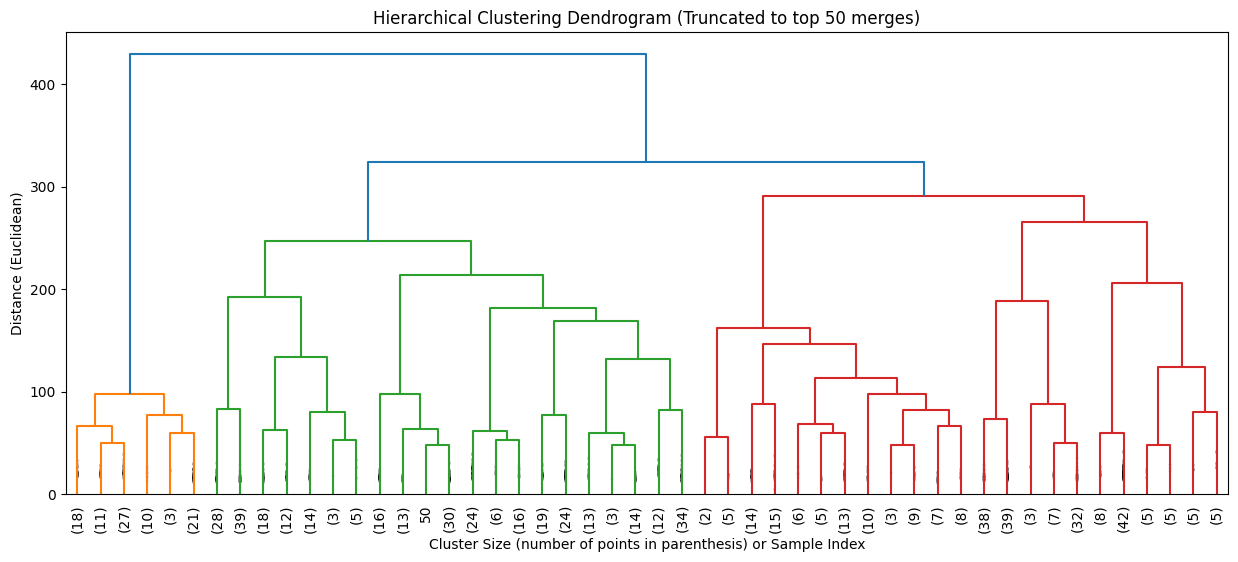

C:\Users\mardin\AppData\Local\Temp\ipykernel_14748\3079479650.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='KMeans_Label', data=results_df, ax=ax[0], palette='viridis')
C:\Users\mardin\AppData\Local\Temp\ipykernel_14748\3079479650.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Agg_Label', data=results_df, ax=ax[1], palette='magma')


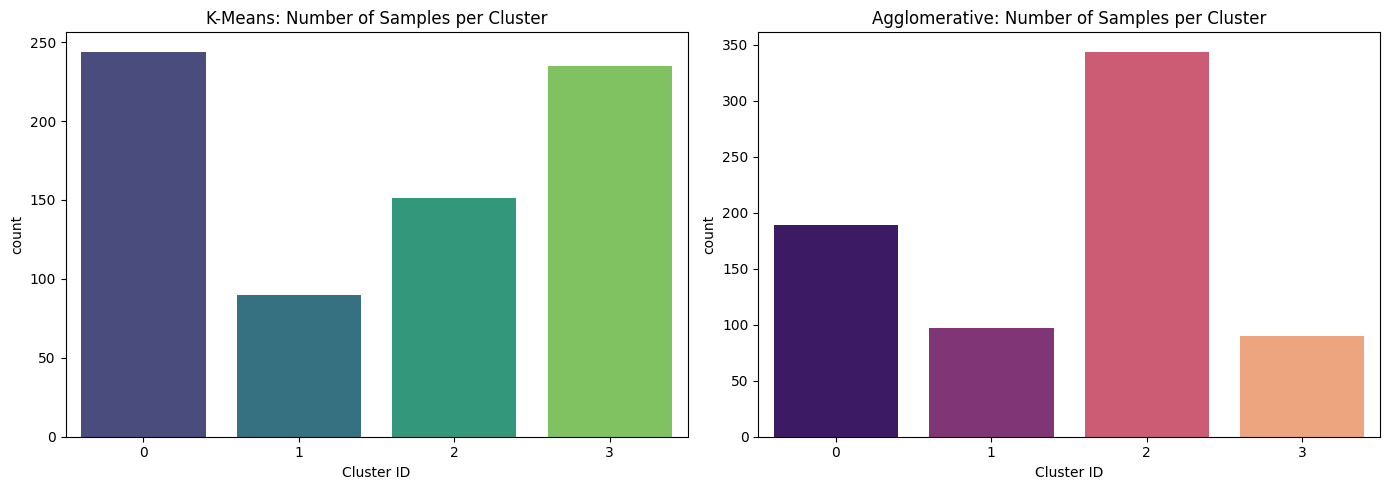


--- K-Means Clustering Quality Check ---
KMeans_Label     0   1   2   3
True_Language                 
German          90   0  28  62
Italian          9   0  85  86
Korean         141   0  38   1
Spanish          4  90   0  86


In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage


Z = linkage(X_pca, method='ward')

plt.figure(figsize=(15, 6))
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=50,                   
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,   
    show_leaf_counts=True   
)
plt.title('Hierarchical Clustering Dendrogram (Truncated to top 50 merges)')
plt.xlabel('Cluster Size (number of points in parenthesis) or Sample Index')
plt.ylabel('Distance (Euclidean)')
plt.show()



results_df = pd.DataFrame({
    'True_Language': y,
    'KMeans_Label': kmeans_labels,
    'Agg_Label': agg_labels
})

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='KMeans_Label', data=results_df, ax=ax[0], palette='viridis')
ax[0].set_title('K-Means: Number of Samples per Cluster')
ax[0].set_xlabel('Cluster ID')

sns.countplot(x='Agg_Label', data=results_df, ax=ax[1], palette='magma')
ax[1].set_title('Agglomerative: Number of Samples per Cluster')
ax[1].set_xlabel('Cluster ID')

plt.tight_layout()
plt.show()


print("\n--- K-Means Clustering Quality Check ---")
print(pd.crosstab(results_df['True_Language'], results_df['KMeans_Label']))


## Part (b): Optimal Number of Clusters

In this section, we determine the optimal number of clusters ($k$) without using the ground truth labels. We employ two standard methods:

1.  **Elbow Method (for K-Means):** We plot the sum of squared distances (Inertia) against $k$. The optimal $k$ is often found at the "elbow" of the curve, where adding more clusters yields diminishing returns in variance reduction.
2.  **Silhouette Score (for Agglomerative Clustering):** We calculate the Silhouette Coefficient for different values of $k$. A higher score indicates that samples are better matched to their own cluster and worse matched to neighboring clusters.


### 1. Elbow Method (K-Means)

We will test values of $k$ from 2 to 10. We expect the inertia to decrease as $k$ increases. The goal is to identify the point where the rate of decrease slows down significantly.


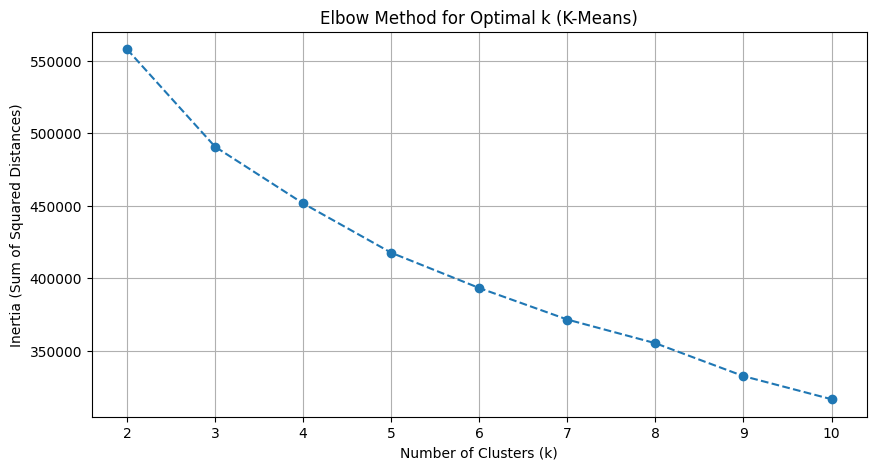

In [19]:
inertia_values = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


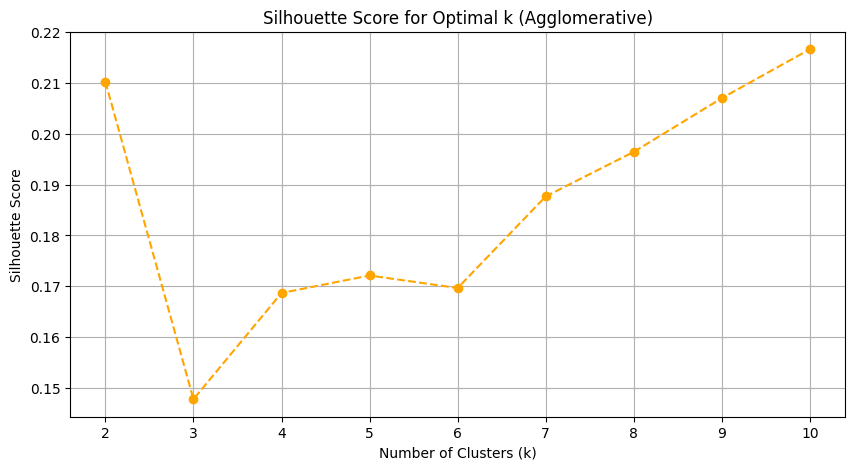

In [20]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    labels = agg.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='orange', linestyle='--')
plt.title('Silhouette Score for Optimal k (Agglomerative)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()


### Final Conclusion on Optimal Number of Clusters

Based on the analysis of both methods:

1.  **Silhouette Score:** The global maximum is at $k=2$ (likely due to the strong male/female gender distinction in audio features). However, there is a distinct **local peak at $k=4$**, which outperforms $k=3$ and $k=5$.
2.  **Elbow Method:** Shows a diminishing return in variance reduction around $k=4$.
3.  **Domain Knowledge:** The dataset consists of exactly **4 languages**.

**Decision:** We select **$k=4$** as the optimal number of clusters for this task, as it aligns with the ground truth and represents the best balance in the Silhouette score for non-binary classification.


## Part (c): Visualization

In this section, we visualize the clustering results in a 2D space.
Since we have already performed PCA to reduce dimensionality, we will utilize the first two Principal Components (PC1 and PC2) as our x and y axes. This allows us to inspect how well the algorithms (K-Means and Agglomerative) have separated the data into 4 distinct groups.


In [21]:
k_optimal = 4

kmeans_final = KMeans(n_clusters=k_optimal, init='k-means++', n_init=10, random_state=42)
y_kmeans = kmeans_final.fit_predict(X_pca)

agg_final = AgglomerativeClustering(n_clusters=k_optimal, metric='euclidean', linkage='ward')
y_agg = agg_final.fit_predict(X_pca)


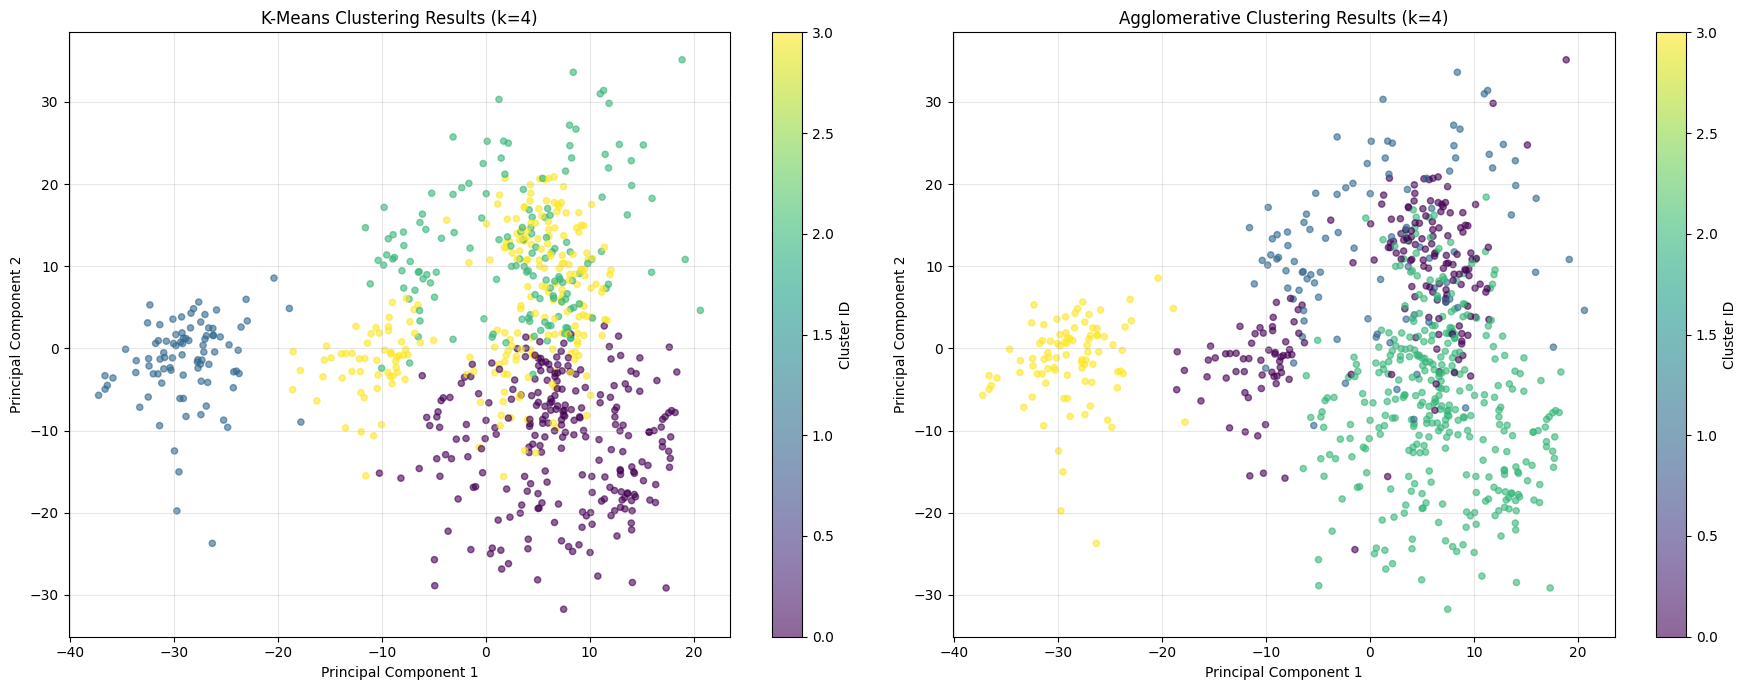

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', alpha=0.6, s=20)
axes[0].set_title(f'K-Means Clustering Results (k={k_optimal})')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')
axes[0].grid(True, alpha=0.3)

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_agg, cmap='viridis', alpha=0.6, s=20)
axes[1].set_title(f'Agglomerative Clustering Results (k={k_optimal})')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
plt.colorbar(scatter2, ax=axes[1], label='Cluster ID')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


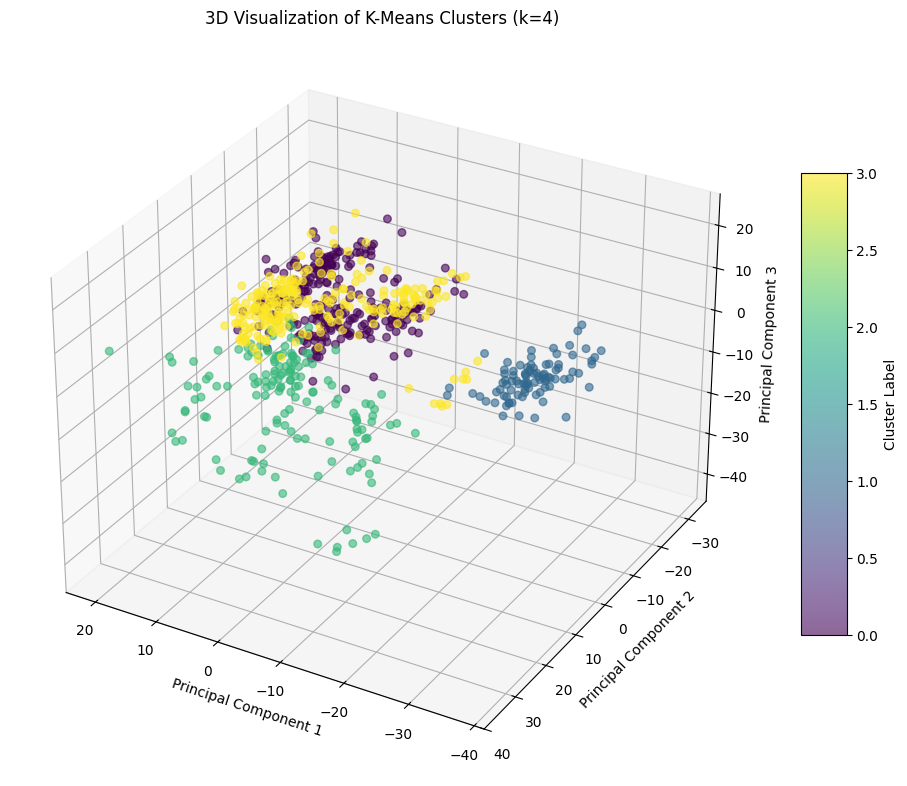

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

x_vals = X_pca[:, 0]
y_vals = X_pca[:, 1]
z_vals = X_pca[:, 2]

scatter = ax.scatter(x_vals, y_vals, z_vals, c=y_kmeans, cmap='viridis', s=30, alpha=0.6)

ax.set_title('3D Visualization of K-Means Clusters (k=4)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Cluster Label')

ax.view_init(elev=30, azim=120)

plt.show()


## Saving Clustering Results

To perform detailed evaluation (Cluster Purity, Silhouette Analysis, and Error Analysis) in the next notebook, we save the assigned cluster labels merged with the original metadata.

We will generate:
1.  `artifacts/clustering_results.csv`: Contains file paths, true labels, and predicted clusters.
2.  `artifacts/y_kmeans.npy` and `artifacts/y_agg.npy`: Raw numpy arrays of the cluster labels.


In [24]:
import os

results_df = features_df.copy()

results_df['cluster_kmeans'] = y_kmeans
results_df['cluster_agg'] = y_agg

artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)

csv_path = artifacts_dir / "clustering_results.csv"
kmeans_npy_path = artifacts_dir / "y_kmeans.npy"
agg_npy_path = artifacts_dir / "y_agg.npy"

results_df.to_csv(csv_path, index=False)
np.save(kmeans_npy_path, y_kmeans)
np.save(agg_npy_path, y_agg)

print(f"✅ Results saved successfully:")
print(f"   - DataFrame: {csv_path}")
print(f"   - K-Means Labels: {kmeans_npy_path}")
print(f"   - Agglomerative Labels: {agg_npy_path}")
print("\nFirst 5 rows of the results:")
print(results_df[['language', 'gender', 'cluster_kmeans', 'cluster_agg']].head())


✅ Results saved successfully:
   - DataFrame: artifacts\clustering_results.csv
   - K-Means Labels: artifacts\y_kmeans.npy
   - Agglomerative Labels: artifacts\y_agg.npy

First 5 rows of the results:
  language  gender  cluster_kmeans  cluster_agg
0  Italian  Female               3            0
1  Italian  Female               3            0
2   German    Male               3            2
3  Italian    Male               2            1
4   Korean  Female               0            2
